<a href="https://colab.research.google.com/github/vulbsti/testing1/blob/master/CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [ ]:
!pip install pyriemann
!pip install mne

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline

In [ ]:
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [ ]:
# mne imports
import mne
from mne import io
from mne.datasets import sample
data_path = sample.data_path()

In [ ]:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [ ]:
def CNNMOD(nb_classes, Chans = 128, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
   
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('ReLU')(block1)
    block1       = MaxPooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('ReLU')(block2)
    block2       = MaxPooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [ ]:
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

model = CNNMOD(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 10, D = 2, F2 = 20, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1,
                               save_best_only=True)

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 200, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

X_train shape: (144, 60, 151, 1)
144 train samples
72 test samples
Epoch 1/200

Epoch 1: val_loss improved from inf to 1.38615, saving model to checkpoint.h5
9/9 - 3s - loss: 1.5910 - accuracy: 0.2500 - val_loss: 1.3862 - val_accuracy: 0.2639 - 3s/epoch - 330ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 1.38615
9/9 - 2s - loss: 1.3935 - accuracy: 0.3056 - val_loss: 1.3862 - val_accuracy: 0.2500 - 2s/epoch - 189ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 1.38615
9/9 - 2s - loss: 1.4875 - accuracy: 0.2014 - val_loss: 1.3863 - val_accuracy: 0.2500 - 2s/epoch - 269ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 1.38615
9/9 - 3s - loss: 1.4300 - accuracy: 0.2431 - 

In [ ]:
model.load_weights('checkpoint.h5')

3/3 [==============================] - 0s 37ms/step
Classification accuracy: 0.902778 
Classification accuracy: 0.944444 


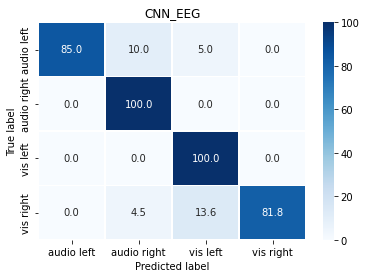

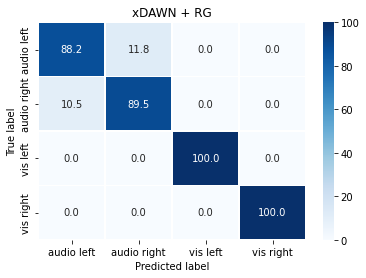

In [ ]:
probs = model.predict(X_test)
preds = probs.argmax(axis = -1)  
acc   = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))


############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)
acc2 = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'CNN_EEG')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')